## Time series clustering of Lab sea FFTs

Adapted from : https://github.com/cerlymarco/MEDIUM_NoteBook/blob/master/TimeSeries_Cluster/TS_Cluster.ipynb

In [1]:
import os
import random
import numpy as np
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

from scipy import stats
import scipy.cluster.hierarchy as sch



In [2]:
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *

### Load files

In [3]:
## Change the local paths

hfls = xr.open_dataset('data/CMIP6.hfls.LabSea.FFT.072022.nc')
pr = xr.open_dataset('data/CMIP6.pr.LabSea.FFT.072022.nc')
psl = xr.open_dataset('data/CMIP6.psl.LabSea.FFT.072022.nc')
tas = xr.open_dataset('data/CMIP6.tas.LabSea.FFT.072022.nc')

In [4]:
models = tas.models.data

### Convert to Numpy Files

In [5]:
tas_npy = tas.tas.data
hfls_npy = hfls.hfls.data
pr_npy = pr.pr.data
psl_npy = psl.psl.data

In [6]:
tas_npy.shape

(36, 901)

Normalize because psl values are too large compared to others

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [8]:
scaler_tas = scaler.fit(tas_npy)
norm_tas = scaler_tas.transform(tas_npy)

scaler_hfls = scaler.fit(hfls_npy)
norm_hfls = scaler_hfls.transform(hfls_npy)

scaler_pr = scaler.fit(pr_npy)
norm_pr = scaler_pr.transform(pr_npy)

scaler_psl = scaler.fit(psl_npy)
norm_psl = scaler_psl.transform(psl_npy)

### Concatenate the FFTs

In [9]:
data = []
data.append(np.expand_dims(norm_tas, axis=2))
data.append(np.expand_dims(norm_hfls, axis=2))
data.append(np.expand_dims(norm_pr, axis=2))
data.append(np.expand_dims(norm_psl, axis=2))
data = np.concatenate(data, axis = 2)

In [10]:
data.shape # 36 models, 901 timesteps, 4 inputs

(36, 901, 4)

### Example plots of a individual models

Text(0.5, 0, 'Time')

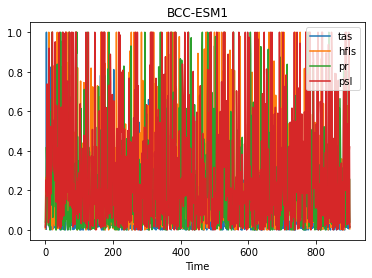

In [11]:
plt.plot(data[11])
plt.legend(['tas','hfls','pr', 'psl'])
plt.title(models[11]); plt.xlabel('Time')

Text(0.5, 0, 'Time')

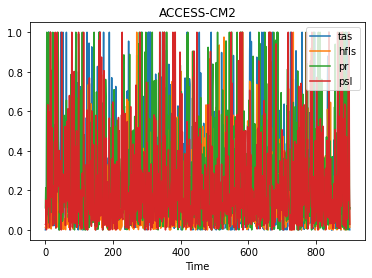

In [12]:
plt.plot(data[16])
plt.legend(['tas','hfls','pr', 'psl'])
plt.title(models[16]); plt.xlabel('Time')

Text(0.5, 0, 'Time')

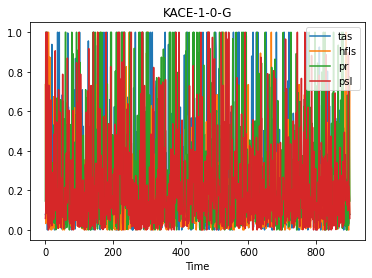

In [13]:
plt.plot(data[32])
plt.legend(['tas','hfls','pr', 'psl'])
plt.title(models[32]); plt.xlabel('Time')

## Dimensionality Reduction

Using an encoder-decoder network to represent different timeseries in the latent space. Here the latent space is '36'--the number of models in the dataset

In [14]:
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

def get_autoencoder(data):
    
    set_seed(33)

    input_layer = Input(shape=(data.shape[1], data.shape[2]))
    
    encoder = TimeDistributed(Dense(200, activation='tanh'))(input_layer)
    encoder = TimeDistributed(Dense(50, activation='tanh'))(encoder)
    latent = TimeDistributed(Dense(36, activation='tanh'))(encoder)
    decoder = TimeDistributed(Dense(50, activation='tanh'))(latent)
    decoder = TimeDistributed(Dense(200, activation='tanh'))(decoder)

    out = TimeDistributed(Dense(data.shape[2]))(decoder)

    autoencoder = Model(inputs=input_layer, outputs=out)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

In [15]:
autoencoder = get_autoencoder(data)
autoencoder.summary()

Metal device set to: Apple M1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 901, 4)]          0         
                                                                 
 time_distributed (TimeDistr  (None, 901, 200)         1000      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 901, 50)          10050     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 901, 36)          1836      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 901, 50)          1850      
 tributed)                     

2022-07-20 09:33:27.552844: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-20 09:33:27.553300: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Train the encoder-decoder network on the FFT dataset

In [26]:
es = EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True, verbose=1, patience=0)

autoencoder = get_autoencoder(data)
autoencoder.fit(data,data, epochs=25, verbose=1, validation_data=(data,data), callbacks=[es])

Epoch 1/25
1/2 [==============>...............] - ETA: 0s - loss: 0.1013

2022-07-20 09:38:17.575399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 09:38:17.757930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 140ms/step - loss: 0.0976 - val_loss: 0.0409
Epoch 2/25
2/2 [==============================] - 0s 49ms/step - loss: 0.0395 - val_loss: 0.0255
Epoch 2: early stopping


Currently, I am training on ALL the dataset, because we want to see how the models are clustered (unlike splitting between train and validation). The trained model then can be used with observational reanalysis to see where it lies in this set of clusters.

1/1 [==============================] - 0s 154ms/step


2022-07-20 09:33:59.156343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Text(0, 0.5, 'mse')

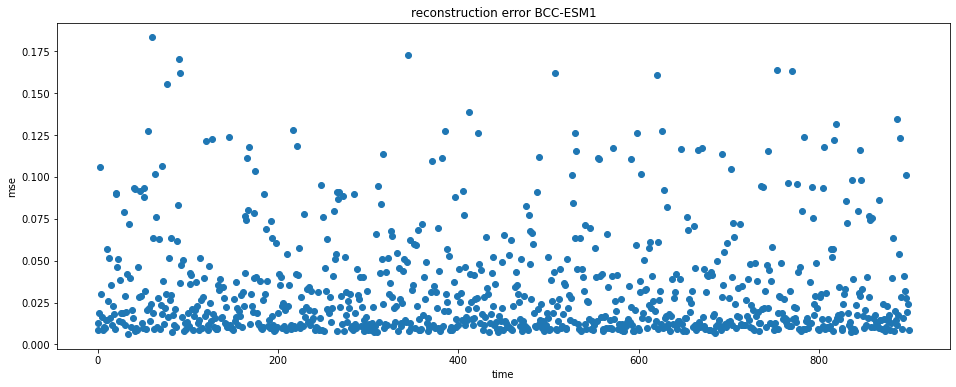

In [17]:
predictions = autoencoder.predict(data[[11]])
mse = np.mean(np.power(data[[11]] - predictions, 2), axis=2)

plt.figure(figsize=(16,6))
plt.scatter(range(data.shape[1]), mse)
plt.title('reconstruction error '+models[11])
plt.xlabel('time'); plt.ylabel('mse')

## Correlation Clustering

First I tried with correlation cluster, it was not meaningful in terms of the 'distances' it was measuring. 

#### Kolmogorov-Smirnov Clustering

Kolmogorov-Smirnov (K-S) statistic is used to compare and measure samples. Specifically, K-S statistic is known for capturing non-linear dependencies. 

A few related papers:

Zhang, B., Chen, R. Nonlinear Time Series Clustering Based on Kolmogorov-Smirnov 2D Statistic. J Classif 35, 394–421 (2018). https://doi.org/10.1007/s00357-018-9271-0

Zhu, Y., Deng, Q., Huang, D., Jing, B. and Zhang, B. (2021), Clustering based on Kolmogorov–Smirnov statistic with application to bank card transaction data. J R Stat Soc Series C, 70: 558-578. https://doi.org/10.1111/rssc.12471

In [27]:
def KScoeff(df):
    
    ks_matrix = np.zeros((len(df),len(df)))
    for i in range(len(df)):
        for j in range(i+1,len(df)):
            ks_test = stats.ks_2samp(df[i], df[j])
            ks_matrix[i,j] = ks_test.statistic
            ks_matrix[j,i] = ks_test.statistic
            
    return ks_matrix

##### Simple clustering using K-S statistic

2/2 [==============================] - 0s 22ms/step


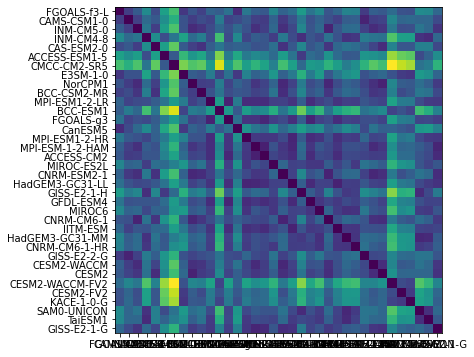

In [22]:
df = np.mean(np.power(data - autoencoder.predict(data), 2), axis=2)
ks_matrix = KScoeff(df)

plt.figure(figsize=(6,6))
plt.imshow(ks_matrix)
plt.xticks(range(len(models)), models)
plt.yticks(range(len(models)), models)
np.set_printoptions(False)

##### Hierarchical Clustering using K-S Statistic

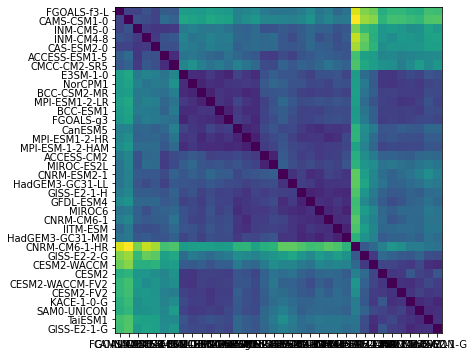

In [30]:
d = sch.distance.pdist(ks_matrix)
L = sch.linkage(d, method='ward')
ind = sch.fcluster(L, d.max(), 'distance')
dendrogram = sch.dendrogram(L, no_plot=True)

df = [df[i] for i in dendrogram['leaves']]
labels = [models[i] for i in dendrogram['leaves']]
ks_matrix = KScoeff(df)

plt.figure(figsize=(6,6))
plt.imshow(ks_matrix)
plt.xticks(range(len(models)), labels)
plt.yticks(range(len(models)), labels)
np.set_printoptions(False)

(array([  5,  15,  25,  35,  45,  55,  65,  75,  85,  95, 105, 115, 125,
        135, 145, 155, 165, 175, 185, 195, 205, 215, 225, 235, 245, 255,
        265, 275, 285, 295, 305, 315, 325, 335, 345, 355]),
 [Text(5, 0, 'FGOALS-f3-L'),
  Text(15, 0, 'CAMS-CSM1-0'),
  Text(25, 0, 'INM-CM5-0'),
  Text(35, 0, 'INM-CM4-8'),
  Text(45, 0, 'CAS-ESM2-0'),
  Text(55, 0, 'ACCESS-ESM1-5'),
  Text(65, 0, 'CMCC-CM2-SR5'),
  Text(75, 0, 'E3SM-1-0'),
  Text(85, 0, 'NorCPM1'),
  Text(95, 0, 'BCC-CSM2-MR'),
  Text(105, 0, 'MPI-ESM1-2-LR'),
  Text(115, 0, 'BCC-ESM1'),
  Text(125, 0, 'FGOALS-g3'),
  Text(135, 0, 'CanESM5'),
  Text(145, 0, 'MPI-ESM1-2-HR'),
  Text(155, 0, 'MPI-ESM-1-2-HAM'),
  Text(165, 0, 'ACCESS-CM2'),
  Text(175, 0, 'MIROC-ES2L'),
  Text(185, 0, 'CNRM-ESM2-1'),
  Text(195, 0, 'HadGEM3-GC31-LL'),
  Text(205, 0, 'GISS-E2-1-H'),
  Text(215, 0, 'GFDL-ESM4'),
  Text(225, 0, 'MIROC6'),
  Text(235, 0, 'CNRM-CM6-1'),
  Text(245, 0, 'IITM-ESM'),
  Text(255, 0, 'HadGEM3-GC31-MM'),
  Text(265, 0,

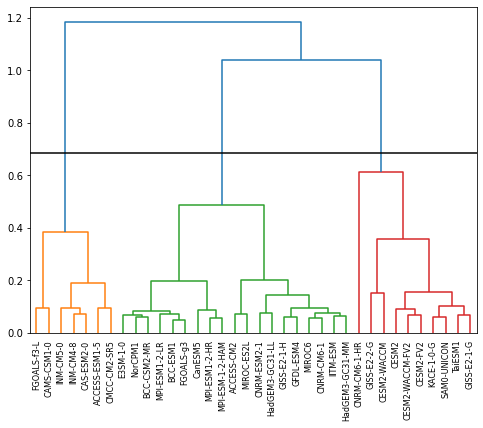

In [31]:
plt.figure(figsize=(8,6))
dendrogram = sch.dendrogram(L, labels=models)
plt.axhline(d.max(), c='black')
plt.xticks(rotation=90)